In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
import random
import cv2
from time import time

import torch 
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision import datasets
import torch.nn as nn
from torchvision.transforms import ToTensor 
import torchvision.transforms as transforms 
from torch.utils.data import Dataset

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [2]:
train_data = pd.read_csv(r'train.csv')
test_data = pd.read_csv(r'test.csv')
sample = pd.read_csv(r'sample_submission.csv')

In [3]:
display(train_data.head(10))
display(test_data.head(1))

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (42000, 785)
Test data shape: (28000, 784)


In [5]:
print(f'The highest value in dataset: {train_data.max().max()}')

The highest value in dataset: 255


In [6]:
Y = train_data['label']
X = train_data.drop(['label'], axis = 1)

# Normalize the data to range 0-1
X = X / 255.0
X_test = test_data / 255.0

X.describe().round(2)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.00,42000.00,42000.00,42000.00,42000.00,42000.00,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.02,0.01,0.01,0.01,0.00,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,1.00,0.99,0.99,1.00,0.24,0.0,0.0,0.0,0.0


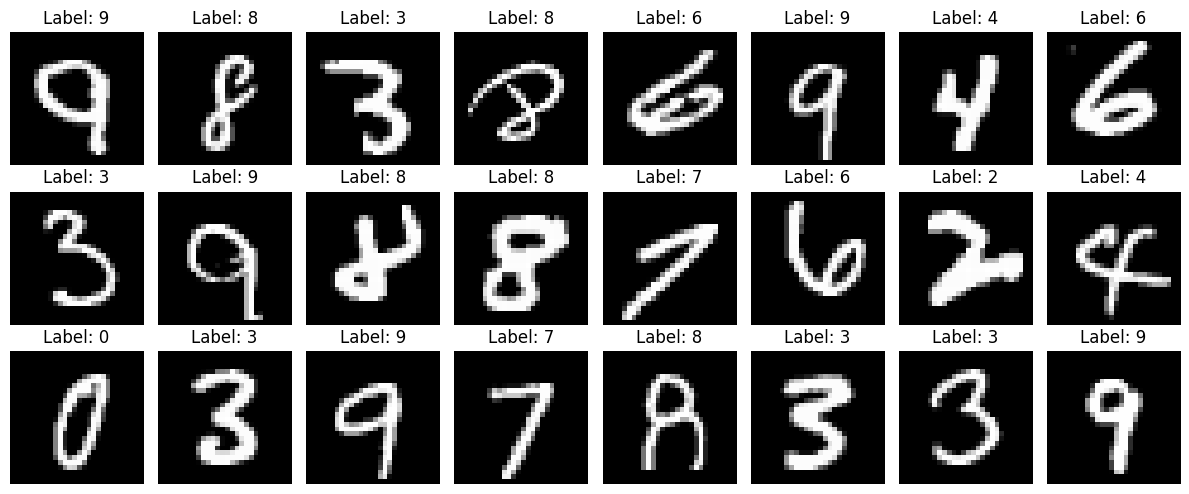

In [7]:
# Vizualization of images and its labels
fig, axes = plt.subplots(3,8, figsize = (12,5))
axes = axes.flatten()
indices = random.sample(range(len(train_data)), 24)

for i, idx in enumerate(indices):
    image = train_data.iloc[idx, 1:].values.reshape(28, 28)  # Reshape from 1D to 2D
    label = train_data.iloc[idx, 0]  # Labelling
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

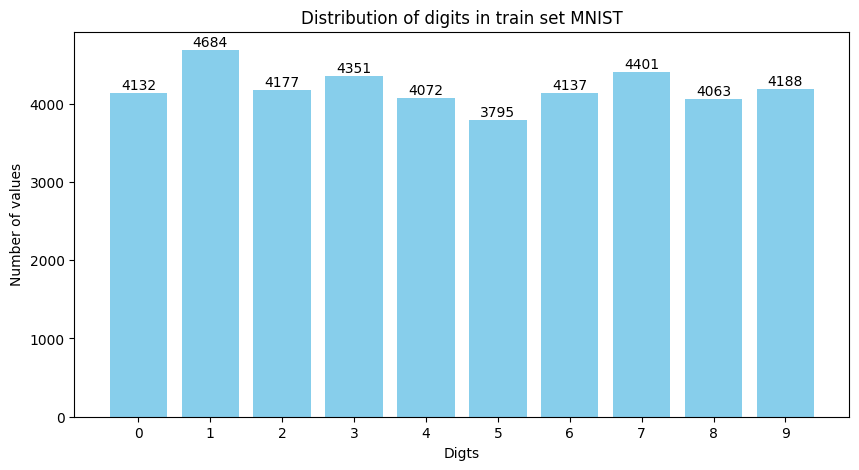

In [8]:
def bar_values(bars):
    '''The function adds labels to the bars in the bar chart.'''
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 5, int(height),
                 ha='center', va='bottom')
        
#Count the number of occurrences of each label
label_counter = Y.value_counts().sort_index()

plt.figure(figsize=(10, 5))
bars = plt.bar(label_counter.index, label_counter.values, color='skyblue')
bar_values(bars)

plt.xticks(range(10))
plt.xlabel('Digts')
plt.ylabel('Number of values')
plt.title('Distribution of digits in train set MNIST')
plt.show()

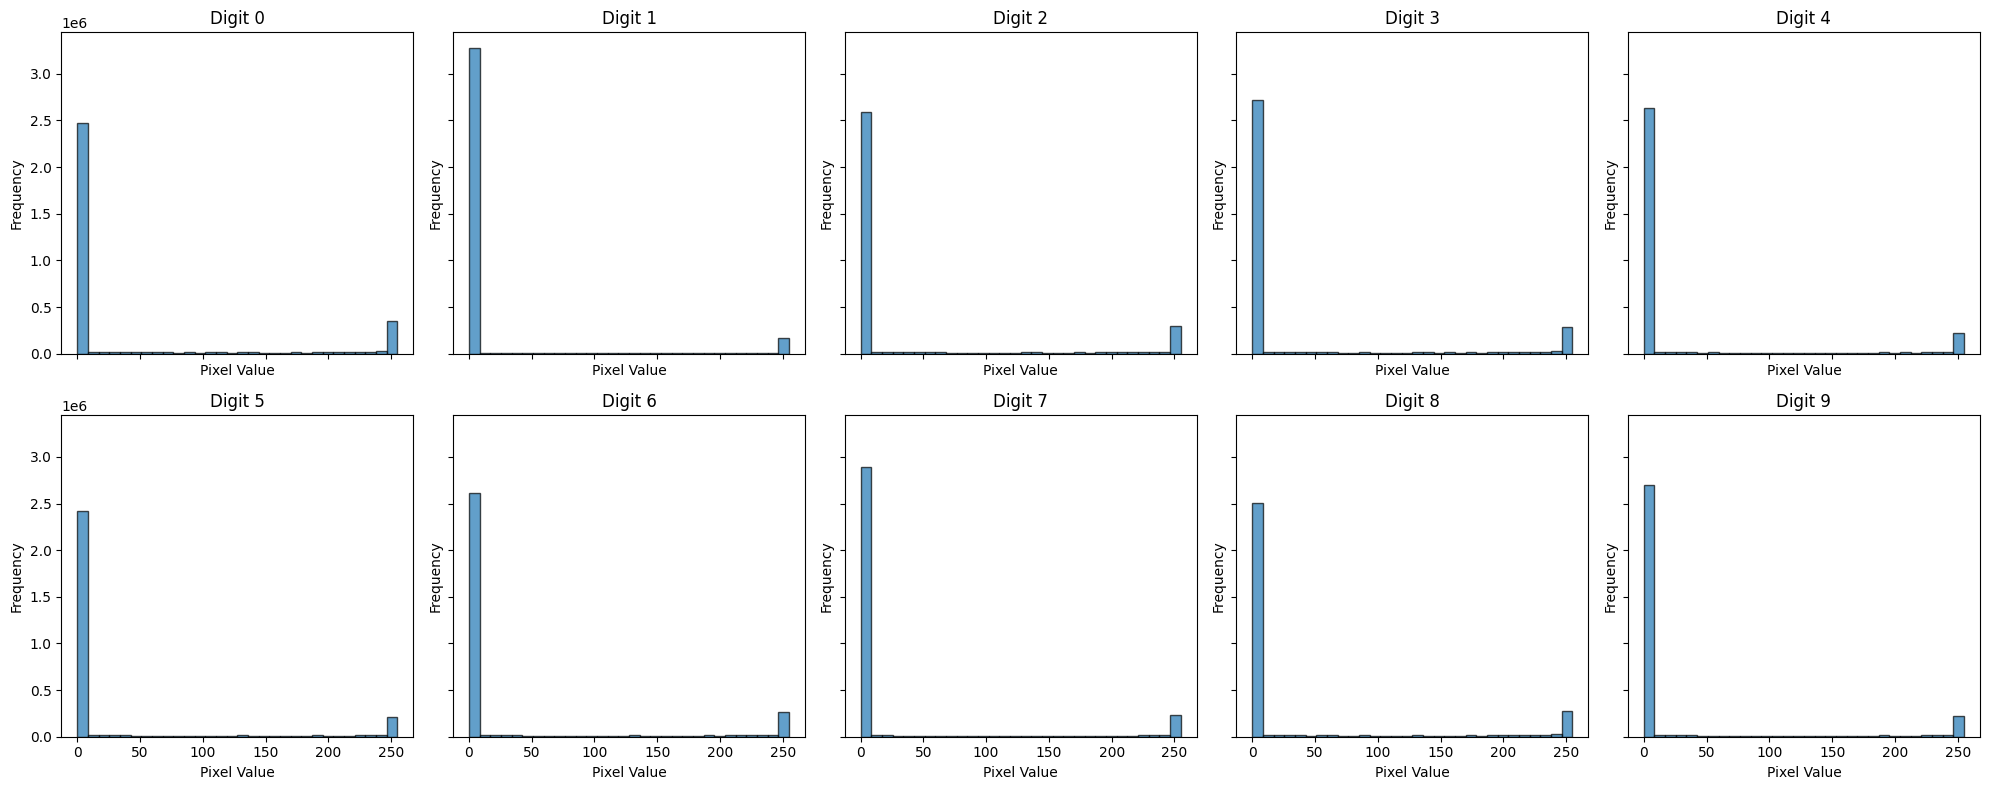

In [9]:
digit_pixel_values = {i: [] for i in range(10)}

# Iteration through the DataFrame rows
for _, row in train_data.iterrows():
    label = row['label']
    pixels = row.drop('label').values  # Retrieve pixel values (all columns except ‘label’)
    digit_pixel_values[label].extend(pixels)


fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(10):
    axes[i].hist(digit_pixel_values[i], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Digit {i}')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42, shuffle=True)

In [11]:
print("X_train shape is : ",X_train.shape)
print("Y_train shape is : ", Y_train.shape)
print("X_val shape is " , X_val.shape)
print("Y_val shape is " , Y_val.shape)

X_train shape is :  (33600, 784)
Y_train shape is :  (33600,)
X_val shape is  (8400, 784)
Y_val shape is  (8400,)


In [12]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, Y_train)
y_pred = logistic_regression.predict(X_val)

acc_logr = round(accuracy_score(Y_val, y_pred) * 100, 2)
conf_matrix = confusion_matrix(Y_val, y_pred)
class_report = classification_report(Y_val, y_pred)

print(f"Accuracy on validation data: {acc_logr}%")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy on validation data: 92.17%
Confusion Matrix:
[[789   0   1   1   3  13   7   0   2   0]
 [  0 888   4   0   1   4   1   2   7   2]
 [  4  11 762  11  13   7  11   8  18   1]
 [  1   3  25 828   0  33   2   7  23  15]
 [  3   2   4   1 787   2   9   4   4  23]
 [  8   2   6  22   8 621  18   3  11   3]
 [  7   1   6   0   4   8 754   1   3   1]
 [  0   2  10   7  11   4   0 825   3  31]
 [  3  12   6  29   7  27   6   4 736   5]
 [  6   4   3  13  18   5   0  30   7 752]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       816
           1       0.96      0.98      0.97       909
           2       0.92      0.90      0.91       846
           3       0.91      0.88      0.90       937
           4       0.92      0.94      0.93       839
           5       0.86      0.88      0.87       702
           6       0.93      0.96      0.95       785
           7       0.93      0.92      0.93       893
     

/Users/franekbiskup/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
train_conf_matrix = confusion_matrix(Y_train, logistic_regression.predict(X_train))
train_conf_matrix

array([[3240,    0,    6,    5,    3,   21,   19,    4,   15,    3],
       [   0, 3695,   12,   15,    3,   11,    2,    6,   26,    5],
       [   7,   27, 3056,   49,   34,   11,   26,   34,   70,   17],
       [   7,   13,   65, 3128,    3,   97,    9,   21,   45,   26],
       [   5,   14,   14,    4, 3066,    4,   21,    8,   13,   84],
       [  24,    9,   22,   89,   29, 2792,   37,    8,   60,   23],
       [  16,    5,   12,    0,   17,   33, 3260,    1,    7,    1],
       [   5,   12,   37,    9,   17,    5,    3, 3328,    4,   88],
       [  20,   52,   20,   76,   11,   54,   13,    8, 2934,   40],
       [  13,   12,    7,   34,   64,   19,    0,   87,   25, 3089]])

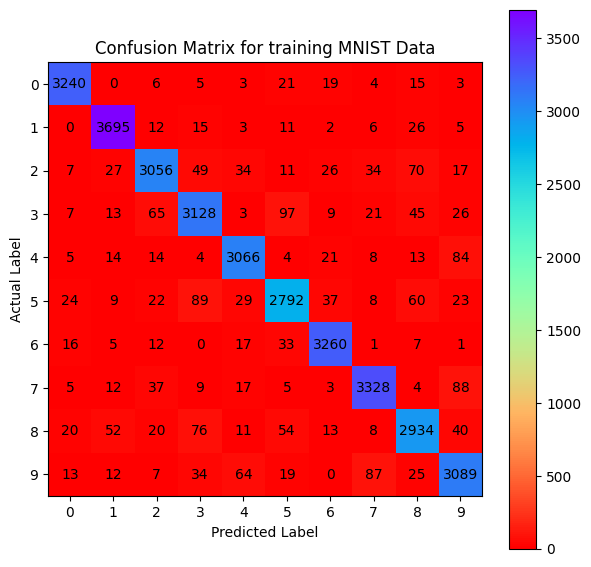

In [56]:
plt.figure(figsize=(7,7))
plt.imshow(train_conf_matrix,cmap='rainbow_r')
plt.title("Confusion Matrix for training MNIST Data")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.colorbar()

width,height = train_conf_matrix.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(train_conf_matrix[x][y]),xy=(y,x),horizontalalignment='center',verticalalignment='center')
plt.show()

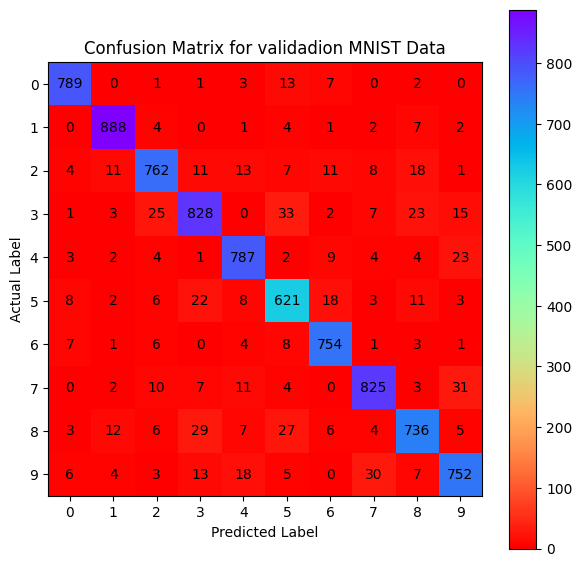

In [15]:
plt.figure(figsize=(7,7))
plt.imshow(conf_matrix,cmap='rainbow_r')
plt.title("Confusion Matrix for validadion MNIST Data")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.colorbar()

width,height = conf_matrix.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(conf_matrix[x][y]),xy=(y,x),horizontalalignment='center',verticalalignment='center')
plt.show()

# Deep learning 

In [16]:
def df_to_tensor(df):
    df = df.astype(float)
    numpy_array = df.values
    to_tensor = torch.tensor(numpy_array, dtype=torch.float32)
    return to_tensor

In [17]:
X_d_train = df_to_tensor(X_train)
Y_d_train = df_to_tensor(Y_train)

#X_d_test = df_to_tensor
#Y_d_test = df_to_tensor

In [18]:
class Data(Dataset):
    def __init__(self, X , Y):
        self.X = torch.tensor(X.values, dtype= torch.float32)
        self.Y = torch.tensor(Y.values, dtype= torch.long)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
train_dataset = Data(X_train, Y_train)
test_dataset = Data(X_val, Y_val)

In [19]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test, batch_size = batch_size, shuffle=False)

In [37]:
# model 1
class nnSimple(nn.Module):
    def __init__(self):
        super(nnSimple, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  

        self.dropout = nn.Dropout(p=0.2)      

    def forward(self, x):
        x = x.view(-1, 28*28)  
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x) 
        return x

In [45]:
model1 = nnSimple()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr = 0.001, momentum = 0.85)

In [39]:
# model 2 
class nnClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p = 0.2)
        self.log_softmax = F.log_softmax

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        x = self.log_softmax(self.fc5(x), dim = 1)

        return x

In [40]:
model2 = nnClassifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr = 0.01, momentum = 0.85)

In [46]:
# Loop for nnSimple model
num_epochs = 25

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    model1.train() # set the model into training mode
    correct = 0
    total = 0
    running_loss = 0.0
    
    # training loop
    for data in train_loader:
        # Downloading data from the dataloader
        inputs, targets = data
        # Zeroing gradients
        optimizer.zero_grad()
        # Prediction
        pred = model1(inputs)
        # Loss calculation
        loss = criterion(pred, targets)
        # Backpropagation (calculation of gradients)
        loss.backward()
        # Weights update
        optimizer.step()
        # Summary of losses to be displayed
        running_loss += loss.item()
        # Class prediction (choose the index of the largest value)
        _, predicted = torch.max(pred.data, 1)
        # Counting correct predictions
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    # Calculation of the accuracy for a given epoch
    train_accuracy = 100 * correct / total
    # Recording loss and accuracy
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    
    model1.eval() # set the model into evaluation mode
    val_loss = 0.0
    correct = 0 
    total = 0
    
    # validation loop       
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            pred = model1(inputs)
            loss = criterion(pred, targets)
            val_loss += loss.item()
            _, predicted = torch.max(pred.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Calculation of the accuracy for a given epoch
    val_accuracy = 100 * correct / total
    # Recording loss and accuracy
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)


    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1/25, Train Loss: 2.2285, Train Accuracy: 30.74%, Validation Loss: 2.0933, Validation Accuracy: 59.21%
Epoch 2/25, Train Loss: 1.7789, Train Accuracy: 58.18%, Validation Loss: 1.2889, Validation Accuracy: 74.10%
Epoch 3/25, Train Loss: 1.0863, Train Accuracy: 68.79%, Validation Loss: 0.7733, Validation Accuracy: 81.79%
Epoch 4/25, Train Loss: 0.8001, Train Accuracy: 75.94%, Validation Loss: 0.5994, Validation Accuracy: 85.20%
Epoch 5/25, Train Loss: 0.6716, Train Accuracy: 79.71%, Validation Loss: 0.5089, Validation Accuracy: 86.64%
Epoch 6/25, Train Loss: 0.5928, Train Accuracy: 82.22%, Validation Loss: 0.4563, Validation Accuracy: 88.04%
Epoch 7/25, Train Loss: 0.5392, Train Accuracy: 83.82%, Validation Loss: 0.4214, Validation Accuracy: 88.76%
Epoch 8/25, Train Loss: 0.5043, Train Accuracy: 85.29%, Validation Loss: 0.3941, Validation Accuracy: 89.15%
Epoch 9/25, Train Loss: 0.4737, Train Accuracy: 86.16%, Validation Loss: 0.3747, Validation Accuracy: 89.55%
Epoch 10/25, Train 

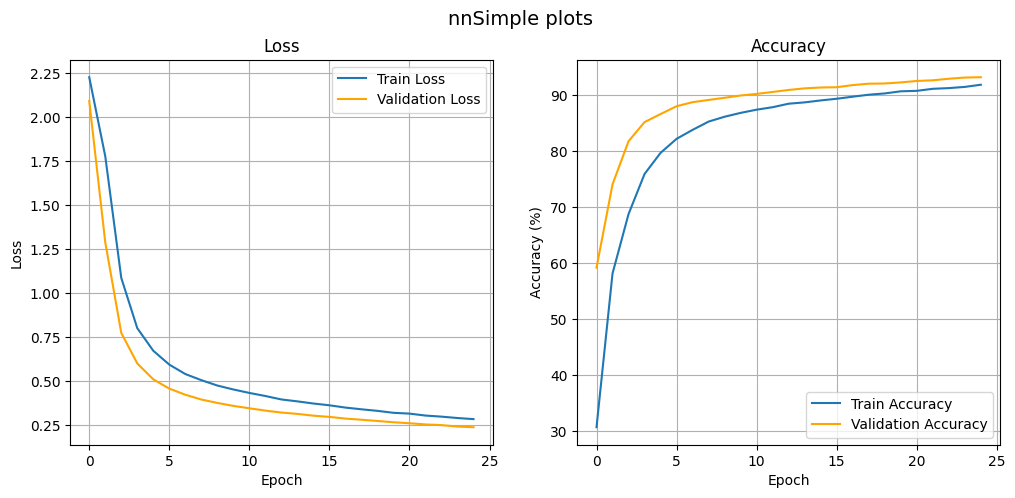

In [47]:
# Loss and accuracy plots
plt.figure(figsize=(12, 5))
plt.suptitle('nnSimple plots', fontsize=14)

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [43]:
# Loop for nnClassifier model
num_epochs = 25

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    model2.train() # set the model into training mode
    correct = 0
    total = 0
    running_loss = 0.0
    
    # training loop
    for data in train_loader:
        # Downloading data from the dataloader
        inputs, targets = data
        # Zeroing gradients
        optimizer.zero_grad()
        # Prediction
        pred = model2(inputs)
        # Loss calculation
        loss = criterion(pred, targets)
        # Backpropagation (calculation of gradients)
        loss.backward()
        # Weights update
        optimizer.step()
        # Summary of losses to be displayed
        running_loss += loss.item()
        # Class prediction (choose the index of the largest value)
        _, predicted = torch.max(pred.data, 1)
        # Counting correct predictions
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    # Calculation of the accuracy for a given epoch
    train_accuracy = 100 * correct / total
    # Recording loss and accuracy
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    
    model2.eval() # set the model into evaluation mode
    val_loss = 0.0
    correct = 0 
    total = 0
    
    # validation loop       
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            pred = model2(inputs)
            loss = criterion(pred, targets)
            val_loss += loss.item()
            _, predicted = torch.max(pred.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Calculation of the accuracy for a given epoch
    val_accuracy = 100 * correct / total
    # Recording loss and accuracy
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)


    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/25, Train Loss: 1.9582, Train Accuracy: 31.13%, Validation Loss: 0.7083, Validation Accuracy: 77.60%
Epoch 2/25, Train Loss: 0.5802, Train Accuracy: 81.97%, Validation Loss: 0.2864, Validation Accuracy: 91.58%
Epoch 3/25, Train Loss: 0.3264, Train Accuracy: 90.72%, Validation Loss: 0.1917, Validation Accuracy: 94.37%
Epoch 4/25, Train Loss: 0.2317, Train Accuracy: 93.58%, Validation Loss: 0.1624, Validation Accuracy: 95.19%
Epoch 5/25, Train Loss: 0.1867, Train Accuracy: 94.77%, Validation Loss: 0.1462, Validation Accuracy: 95.49%
Epoch 6/25, Train Loss: 0.1532, Train Accuracy: 95.79%, Validation Loss: 0.1225, Validation Accuracy: 96.48%
Epoch 7/25, Train Loss: 0.1315, Train Accuracy: 96.55%, Validation Loss: 0.1121, Validation Accuracy: 96.88%
Epoch 8/25, Train Loss: 0.1189, Train Accuracy: 96.75%, Validation Loss: 0.1077, Validation Accuracy: 96.93%
Epoch 9/25, Train Loss: 0.1020, Train Accuracy: 97.22%, Validation Loss: 0.1014, Validation Accuracy: 96.99%
Epoch 10/25, Train 

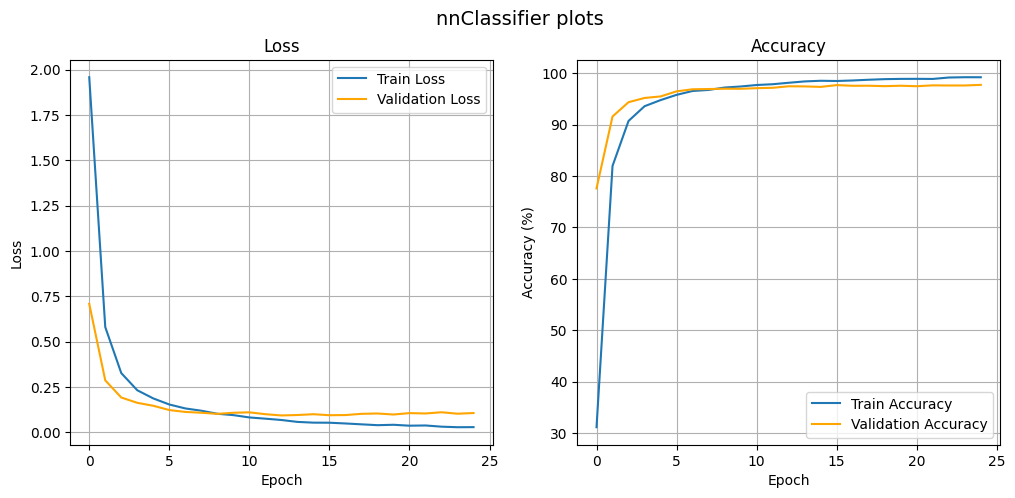

In [44]:
# Loss and accuracy plots
plt.figure(figsize=(12, 5))
plt.suptitle('nnClassifier plots', fontsize=14)

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [48]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [61]:
def plot_confusion_matrix(data_loader, model, device, data_source):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # calculate matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='rainbow_r', xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {data_source}')
    plt.show()


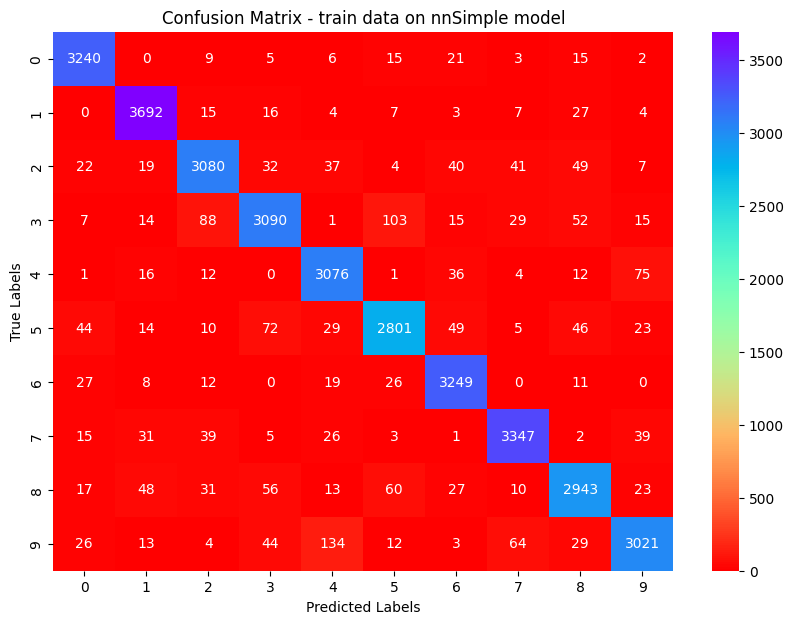

In [65]:
model1.to(device)  
plot_confusion_matrix(train_loader, model1, device, 'train data on nnSimple model')

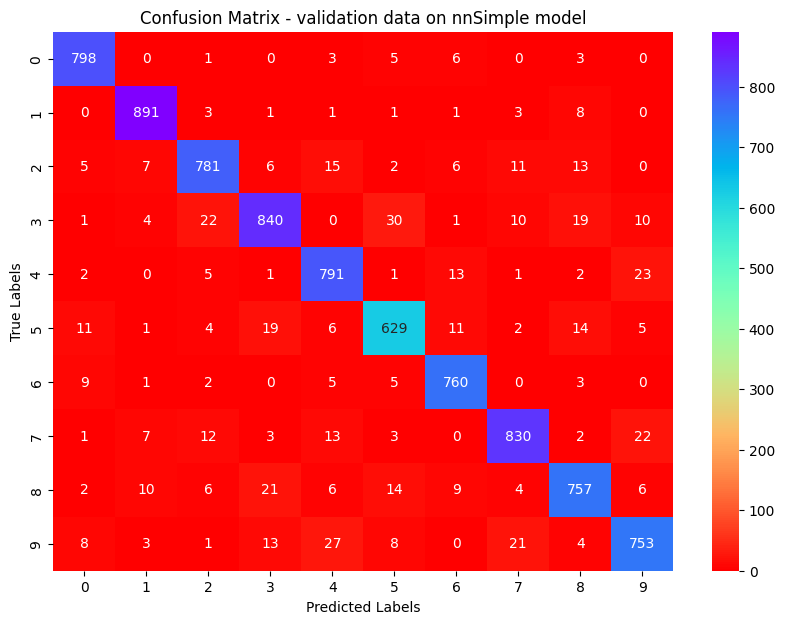

In [64]:
model1.to(device)  
plot_confusion_matrix(val_loader, model1, device, 'validation data on nnSimple model')

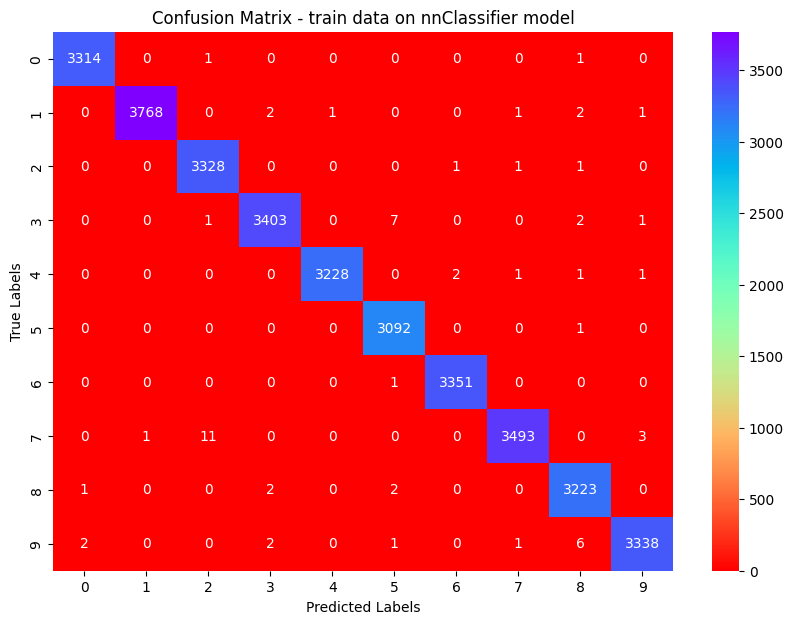

In [67]:
model2.to(device)  
plot_confusion_matrix(train_loader, model2, device, 'train data on nnClassifier model')

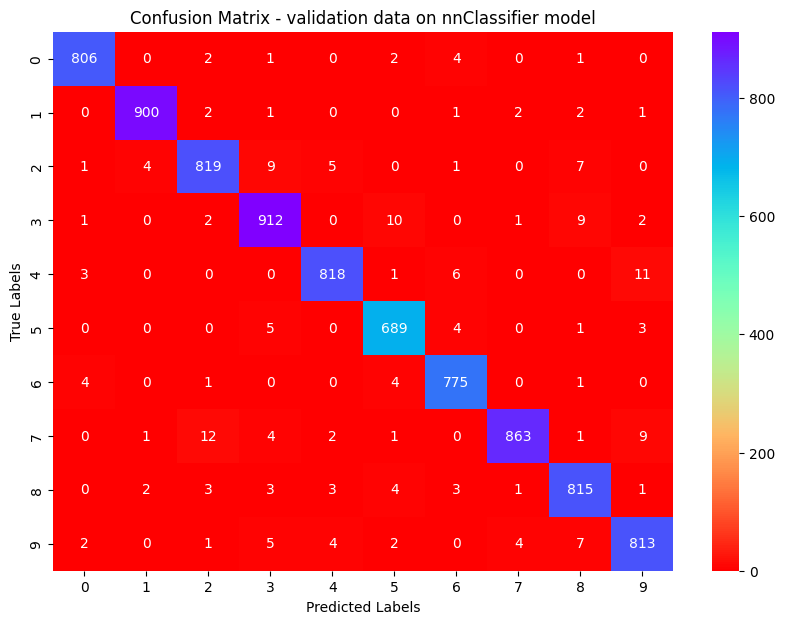

In [68]:
model2.to(device)  
plot_confusion_matrix(val_loader, model2, device, 'validation data on nnClassifier model')